<a href="https://colab.research.google.com/github/jass228/mask_detection_yolov3/blob/main/Mask_detection_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dowload dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andrewmvd/face-mask-detection

 97% 387M/398M [00:02<00:00, 165MB/s]
100% 398M/398M [00:02<00:00, 175MB/s]


In [ ]:
!unzip /content/face-mask-detection.zip

## Create New dataset for YOLO

In [ ]:
classes = ['with_mask','without_mask', 'mask_weared_incorrect']

image_dir = '/content/images'
annot_dir = '/content/annotations'

In [ ]:
def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.png'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

In [ ]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

In [ ]:
test = getImagesInDir(image_dir)

list_file = open('images_path.txt', 'w')
for i in test:
    list_file.write(i+'\n')
    convert_annotation(annot_dir, '/content/dataset/',i)
list_file.close()
print("end")

end


In [ ]:
%cd /content/drive/MyDrive/mask/scripts

/content/drive/MyDrive/mask/scripts


## Create custom Yolo object detection

### Create train,test dataset

In [ ]:
!python create_file_name.py 
!python create_file_txt.py 

Script start............
Script end............
Script start............
Script end............


### Clone Yolo

In [ ]:
!git clone 'https://github.com/AlexeyAB/darknet.git' '/content/drive/MyDrive/mask/darknet/'

Cloning into '/content/drive/MyDrive/mask/darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.04 MiB | 5.35 MiB/s, done.
Resolving deltas: 100% (10359/10359), done.
Checking out files: 100% (2050/2050), done.


In [ ]:
%cd /content/drive/MyDrive/mask/darknet/
!make

### Download weights for training

In [ ]:
%cd /content/drive/MyDrive/mask/mask_weight/
!wget https://pjreddie.com/media/files/darknet53.conv.74
!wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
#We modify the Makefile by activating the gpu
%cd /content/drive/MyDrive/mask/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!make

In [ ]:
!cp /content/drive/MyDrive/mask/darknet/cfg/yolov3.cfg /content/drive/MyDrive/mask/training/mask_yolov3.cfg

### Training

In [ ]:
!./darknet detector train /content/drive/MyDrive/mask/training/labelled_data.data /content/drive/MyDrive/mask/training/mask_yolov3.cfg /content/drive/MyDrive/mask/mask_weight/darknet53.conv.74 -dont_show 

In [ ]:
%cd /content/drive/MyDrive/mask/darknet/

In [ ]:
!./darknet detector train /content/drive/MyDrive/mask/training/labelled_data.data /content/drive/MyDrive/mask/training/mask_yolov3.cfg /content/drive/MyDrive/mask/backup/mask_yolov3_last.weights -dont_show -map

### Testing

In [ ]:
!./darknet detector test /content/drive/MyDrive/mask/training/labelled_data.data /content/drive/MyDrive/mask/training/mask_yolov3.cfg /content/drive/MyDrive/mask/backup/mask_yolov3_best.weights /content/ingoods_437784_sub12.jpg

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

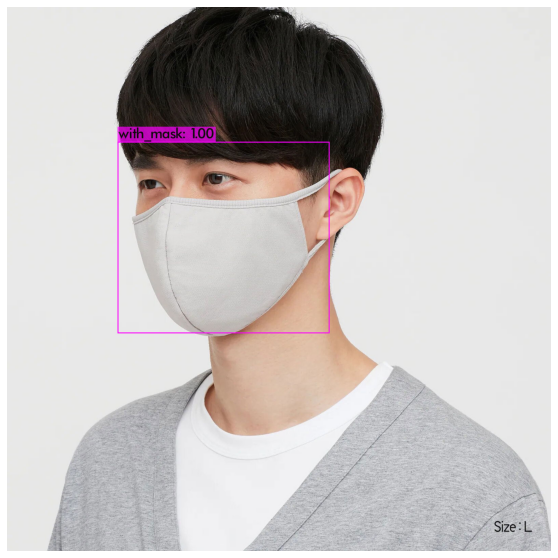

In [ ]:
imShow('predictions.jpg')